# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

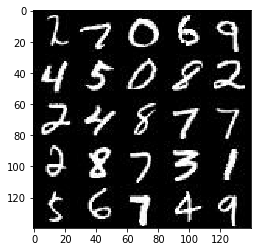

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

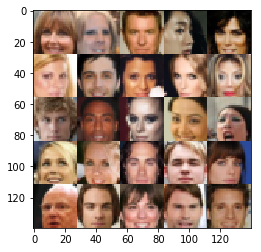

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/home/lpalum/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        # discriminator uses leaky ReLU e.g. set alpha to 0.2 as recommended in DCGAN paper
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        # Use batch normalization for discriminator (discriminator is not used other than training)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        # discriminator uses leaky ReLU e.g. set alpha to 0.2 as recommended in DCGAN paper
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.0 
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        # perform batch normalization during training
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # generator uses ReLU e.g. set alpha to 0.0
        x1 = tf.maximum(alpha * x1, x1) 
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        # perform batch normalization during training
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # generator uses ReLU e.g. set alpha to 0.0
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # make a generator model
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # make a discriminator model and train on real images
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    # make a discriminator model and classify a generated output turn reuse on
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Create loss functions.
    # descriminator real prob = 1
    # descriminator fake (generated) prob = 0
    # generator fake (generated) prob = 1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # descriminator loss is combnation of real and fake image performance.
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get variables to update during optimization 
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    """
     Optimize
     If we don't include the update ops as dependencies on the train step, the 
     tf.layers.batch_normalization layers won't update their population statistics,
     which will cause the model to fail at inference time
     https://github.com/udacity/deep-learning/blob/master/batch-norm/Batch_Normalization_Lesson.ipynb
    """
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    print(epoch_count, batch_size, z_dim, learning_rate, beta1, data_shape, data_image_mode)
    
    samples, losses = [], []
    steps = 0
    
    #print(data_shape, learning_rate)

    #tf.reset_default_graph()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #print(batch_images.shape, input_real.shape)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    
    return losses, samples               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

2 64 100 0.0002 0.5 (60000, 28, 28, 1) L
Epoch 1/2... Discriminator Loss: 3.2621... Generator Loss: 0.0854
Epoch 1/2... Discriminator Loss: 2.0050... Generator Loss: 0.3344
Epoch 1/2... Discriminator Loss: 2.3733... Generator Loss: 0.2082
Epoch 1/2... Discriminator Loss: 2.2466... Generator Loss: 0.3303
Epoch 1/2... Discriminator Loss: 1.8840... Generator Loss: 0.4411
Epoch 1/2... Discriminator Loss: 1.8520... Generator Loss: 0.6366
Epoch 1/2... Discriminator Loss: 1.7338... Generator Loss: 0.3650
Epoch 1/2... Discriminator Loss: 1.6394... Generator Loss: 0.3151
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 0.4824
Epoch 1/2... Discriminator Loss: 1.1602... Generator Loss: 0.9293


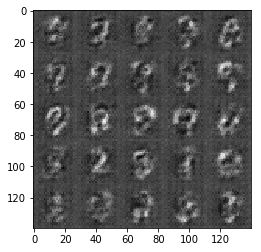

Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.8697
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.5587
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.4571
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.9765


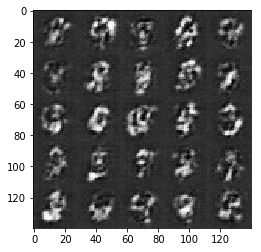

Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.6430
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.5566
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.4808
Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.5993
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.4932
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 0.7827
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 0.7280


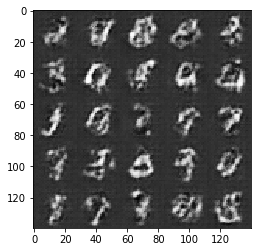

Epoch 1/2... Discriminator Loss: 0.9818... Generator Loss: 1.0741
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.3537
Epoch 1/2... Discriminator Loss: 1.5110... Generator Loss: 0.3070
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 1.5157
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 0.5387
Epoch 1/2... Discriminator Loss: 0.9706... Generator Loss: 1.3071
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 0.2983
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 0.2662


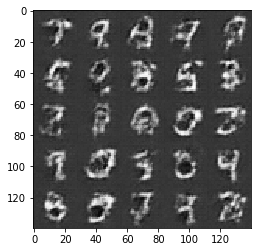

Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.7048... Generator Loss: 0.2295
Epoch 1/2... Discriminator Loss: 1.6230... Generator Loss: 0.2617
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 1.3182
Epoch 1/2... Discriminator Loss: 1.6144... Generator Loss: 0.2599
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 0.9045
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 0.6079
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 0.3579
Epoch 1/2... Discriminator Loss: 0.9322... Generator Loss: 1.2345


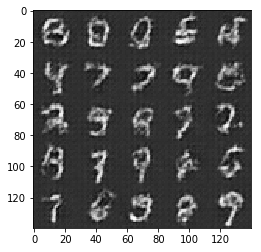

Epoch 1/2... Discriminator Loss: 1.6368... Generator Loss: 0.2515
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.4865
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.3935
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.4816
Epoch 1/2... Discriminator Loss: 0.8219... Generator Loss: 1.2959
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.9199... Generator Loss: 0.1838
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 0.4095
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.8344


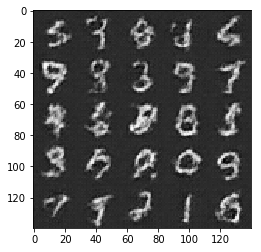

Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.4517
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.4144
Epoch 1/2... Discriminator Loss: 1.7369... Generator Loss: 0.2237
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 0.3288
Epoch 1/2... Discriminator Loss: 0.8993... Generator Loss: 1.2271
Epoch 1/2... Discriminator Loss: 0.9936... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 1.6707... Generator Loss: 0.2398
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 1.2005
Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 0.5032
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 0.5491


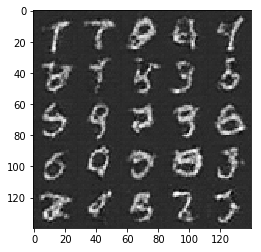

Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 1.7502... Generator Loss: 0.2178
Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 0.7827
Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.2090
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.3117
Epoch 1/2... Discriminator Loss: 1.8470... Generator Loss: 0.1910
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.3716
Epoch 1/2... Discriminator Loss: 1.7039... Generator Loss: 0.2339
Epoch 1/2... Discriminator Loss: 1.0277... Generator Loss: 0.7148
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 1.3587


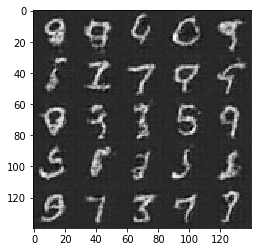

Epoch 1/2... Discriminator Loss: 1.7713... Generator Loss: 0.2115
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.5057
Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 0.3152
Epoch 1/2... Discriminator Loss: 1.6924... Generator Loss: 0.2554
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 0.6781
Epoch 1/2... Discriminator Loss: 0.9010... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 0.6526
Epoch 1/2... Discriminator Loss: 0.7265... Generator Loss: 1.1882
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.4049


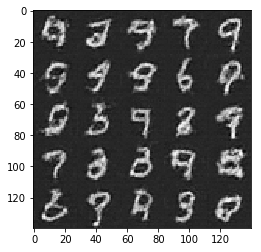

Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.4309
Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 1.0143
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.3125
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 0.6202
Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 1.2141
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 0.5866
Epoch 2/2... Discriminator Loss: 1.8767... Generator Loss: 0.1847
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.4866
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.8827


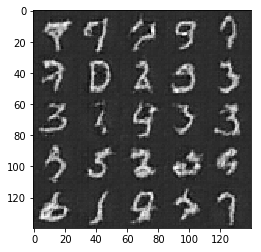

Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.4316
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 0.6223
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.5405
Epoch 2/2... Discriminator Loss: 1.7310... Generator Loss: 0.2270
Epoch 2/2... Discriminator Loss: 1.1903... Generator Loss: 0.4312
Epoch 2/2... Discriminator Loss: 1.6983... Generator Loss: 0.2262
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 1.3378
Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.5411
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.5960
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.6501


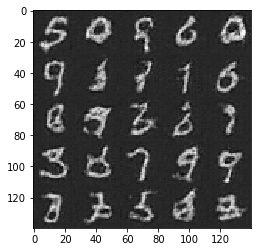

Epoch 2/2... Discriminator Loss: 1.5340... Generator Loss: 0.2845
Epoch 2/2... Discriminator Loss: 1.6528... Generator Loss: 0.2482
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.0504
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 0.6019
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 1.3122
Epoch 2/2... Discriminator Loss: 1.6907... Generator Loss: 0.2370
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.4679
Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 0.5044
Epoch 2/2... Discriminator Loss: 0.5842... Generator Loss: 1.7396


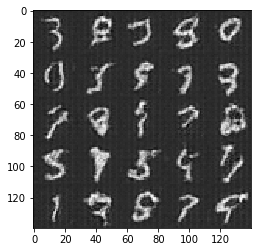

Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 1.8579... Generator Loss: 0.1847
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 0.5852
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 2.6359... Generator Loss: 0.0856
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 0.6640
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.4184
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 0.7562


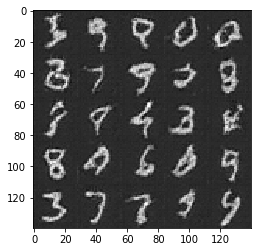

Epoch 2/2... Discriminator Loss: 0.7531... Generator Loss: 1.9828
Epoch 2/2... Discriminator Loss: 0.9358... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 0.9129... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 1.2350
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.5248
Epoch 2/2... Discriminator Loss: 0.9174... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 0.9154... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 2.7854... Generator Loss: 0.0771


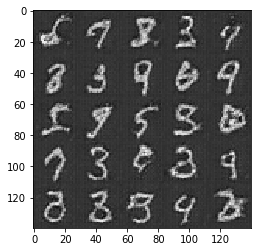

Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.4724
Epoch 2/2... Discriminator Loss: 1.3522... Generator Loss: 0.3812
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 0.6636
Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 0.7178... Generator Loss: 2.5027
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 1.1701... Generator Loss: 0.4581
Epoch 2/2... Discriminator Loss: 0.8939... Generator Loss: 2.6310
Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 0.5707


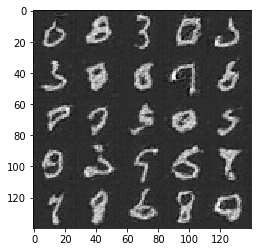

Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.1550... Generator Loss: 0.4766
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.3367
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 0.8481
Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 0.4857
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.1529
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.5517
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 0.6247
Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 0.5747


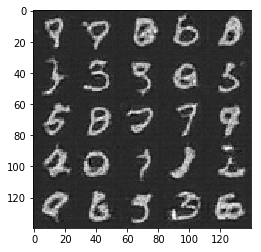

Epoch 2/2... Discriminator Loss: 1.0070... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.4659
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 0.4670
Epoch 2/2... Discriminator Loss: 2.0260... Generator Loss: 0.1540
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 1.1494... Generator Loss: 0.4762
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.3770
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 0.4788
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 1.4449


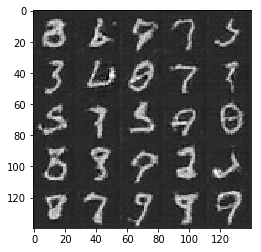

Epoch 2/2... Discriminator Loss: 1.2073... Generator Loss: 0.4417
Epoch 2/2... Discriminator Loss: 1.1451... Generator Loss: 0.4824
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 0.5169
Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 0.6926
Epoch 2/2... Discriminator Loss: 0.6723... Generator Loss: 1.7018
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 0.9377
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 0.6049


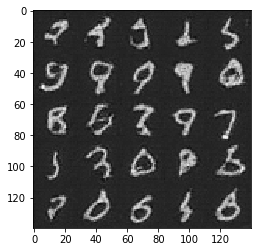

Epoch 2/2... Discriminator Loss: 0.6488... Generator Loss: 1.1200
Epoch 2/2... Discriminator Loss: 1.5670... Generator Loss: 0.2804
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 0.5414
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.3704
Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 0.4949
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 0.7888


In [12]:
# Hyperparameters from the DCGAN paper https://arxiv.org/pdf/1511.06434.pdf
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

1 64 100 0.0002 0.5 (202599, 28, 28, 3) RGB
Epoch 1/1... Discriminator Loss: 4.0955... Generator Loss: 0.0386
Epoch 1/1... Discriminator Loss: 3.3061... Generator Loss: 0.1306
Epoch 1/1... Discriminator Loss: 2.1561... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 2.5741... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 2.3431... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 2.2057... Generator Loss: 0.3218
Epoch 1/1... Discriminator Loss: 2.1633... Generator Loss: 0.3629
Epoch 1/1... Discriminator Loss: 1.6935... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.6869... Generator Loss: 0.3895


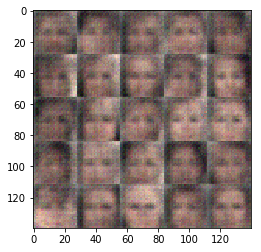

Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.6932... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.6148... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.1008


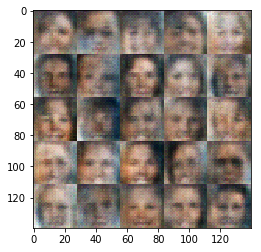

Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.7386... Generator Loss: 0.3085
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 2.2244
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 2.2216
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 0.2943
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.6846... Generator Loss: 0.3586


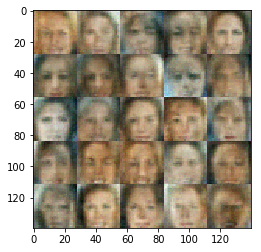

Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 3.4146
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 5.5021
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.3342
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 5.7907
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.3401
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 3.3804
Epoch 1/1... Discriminator Loss: 1.8995... Generator Loss: 0.2239
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 1.8761
Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 3.0270
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 4.6806


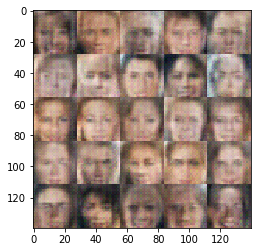

Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 2.9064
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 2.4898
Epoch 1/1... Discriminator Loss: 0.2828... Generator Loss: 2.4849
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 1.3431
Epoch 1/1... Discriminator Loss: 0.2833... Generator Loss: 2.8628
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 2.2655
Epoch 1/1... Discriminator Loss: 0.3402... Generator Loss: 3.7472


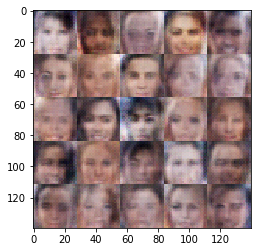

Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.2960
Epoch 1/1... Discriminator Loss: 1.7857... Generator Loss: 0.2377
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 3.2819
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.3798
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 2.2397
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 1.8800
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 4.1216
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.4642


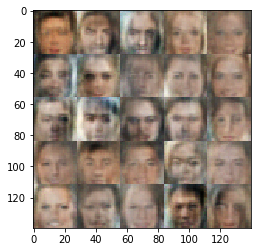

Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 2.7115
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 0.3158
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 1.6948
Epoch 1/1... Discriminator Loss: 1.7271... Generator Loss: 0.2706
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.3172
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 2.7191
Epoch 1/1... Discriminator Loss: 1.7102... Generator Loss: 0.3148
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 2.5096
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 3.4369


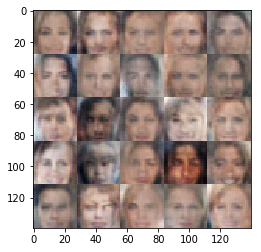

Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.2969
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 4.9581
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 1.5197
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 2.2372
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.2407
Epoch 1/1... Discriminator Loss: 2.0291... Generator Loss: 0.1944


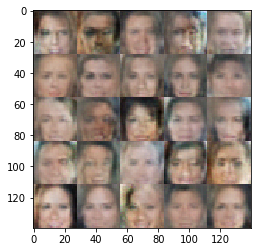

IndexError: list index out of range

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.